# Fase 2 - Extração de Relações Semânticas (SINKT)

Nesta etapa, utilizaremos os conceitos extraídos e o texto dos capítulos (processados na Fase 1) para construir as arestas do grafo de conhecimento.
A extração é feita capítulo a capítulo, buscando relações explícitas no texto entre os conceitos identificados.

**Setup do Ambiente:** Importa bibliotecas, carrega variáveis de ambiente e verifica as dependências necessárias para a execução do notebook.

In [1]:
# Instalação de dependências
!pip install -q networkx matplotlib langchain langchain-openai pydantic tqdm python-dotenv

import os
import json
from enum import Enum
from typing import List
from tqdm import tqdm
from dotenv import load_dotenv
from pydantic import BaseModel, Field
import networkx as nx
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor, as_completed

from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import PydanticOutputParser

# Carregar variáveis de ambiente (.env)
load_dotenv()

if not os.getenv("OPENAI_API_KEY"):
    print("AVISO: OPENAI_API_KEY não encontrada no ambiente.")

**Carregamento de Dados:** Lê os arquivos de conceitos e capítulos gerados na fase anterior, filtrando ruídos e preparando os dados para a extração de relações.

In [2]:
# --- Carregamento dos Artefatos da Fase 1 ---

input_folder = "output/01_extraction" # 📂 Entrada da Fase 1
output_folder = "output/01_extraction" # 📂 Saída também na Fase 1 (Relações brutas)

concepts_path = f"{input_folder}/concepts_map.json"
chapters_path = f"{input_folder}/chapters_content.json"

def load_data():
    # Carregar Conceitos
    if not os.path.exists(concepts_path):
        raise FileNotFoundError(f"Arquivo de conceitos não encontrado: {concepts_path}. Execute o notebook da Fase 1 primeiro.")
    
    with open(concepts_path, 'r', encoding='utf-8') as f:
        concepts = json.load(f)
        
    # Carregar Capítulos
    if not os.path.exists(chapters_path):
        raise FileNotFoundError(f"Arquivo de capítulos não encontrado: {chapters_path}. Execute o notebook da Fase 1 primeiro.")

    with open(chapters_path, 'r', encoding='utf-8') as f:
        chapters = json.load(f)
        
    return concepts, chapters

try:
    final_concepts, chapters = load_data()
    
    # Filtragem: Remover NOISE
    valid_concepts = [c for c in final_concepts if c['tipo'] != 'NOISE']
    
    print(f"Dados carregados com sucesso.")
    print(f"Conceitos Válidos: {len(valid_concepts)}")
    print(f"Capítulos Disponíveis: {len(chapters)}")
    
except Exception as e:
    print(f"Erro crítico: {e}")
    valid_concepts = []
    chapters = []

Dados carregados com sucesso.
Conceitos Válidos: 254
Capítulos Disponíveis: 26


**Indexação de Conceitos:** Cria índices otimizados (mapas) dos conceitos por nome e por capítulo, permitindo buscas rápidas e filtragem de contexto para o LLM.

In [3]:
# --- Indexação para Busca Rápida ---

# 1. Dicionário por Nome (para validação)
concept_dict = {c['nome']: c for c in valid_concepts}

# 2. Dicionário por Capítulo (para enviar apenas o contexto relevante ao LLM)
concepts_by_chapter = {}

for concept in valid_concepts:
    # Um conceito pode ter múltiplos capítulos de origem (ex: "1, 5, 10")
    chapter_ids = [ch.strip() for ch in concept['capitulo_origem'].split(',')]
    for ch_id in chapter_ids:
        if ch_id not in concepts_by_chapter:
            concepts_by_chapter[ch_id] = []
        concepts_by_chapter[ch_id].append(concept['nome'])

print("Amostra de indexação (Capítulo 1):")
print(concepts_by_chapter.get('1', [])[:10])

Amostra de indexação (Capítulo 1):
['Android', 'AWS', 'Azure', 'Big Data', 'Deepin', 'DigiTal Ocean', 'Elementary OS', 'Fedora', 'GCP', 'Linux']


**Definição de Schemas:** Estabelece os modelos de dados (Pydantic) e enumerações para padronizar os tipos de relações e a estrutura da resposta esperada do LLM.

In [4]:
# --- Schemas para Relações ---

class RelationType(str, Enum):
    PREREQUISITE = "PREREQUISITE"
    PART_OF = "PART_OF"
    IS_A = "IS_A"
    USE = "USE"
    RELATED = "RELATED"

class Relation(BaseModel):
    source: str = Field(description="Nome do conceito de origem (deve existir na lista fornecida).")
    target: str = Field(description="Nome do conceito de destino (deve existir na lista fornecida).")
    type: RelationType = Field(description="Tipo da relação pedagógica ou estrutural.")
    explanation: str = Field(description="Breve justificativa da relação (máx 15 palavras).")

class RelationList(BaseModel):
    relations: List[Relation]

print("Schemas de Relação definidos.")

Schemas de Relação definidos.


**Configuração do Extrator de Relações:** Define o modelo LLM e o prompt especializado, instruindo a IA sobre os tipos de relações pedagógicas (IS_A, PART_OF, etc.) a serem identificadas.

In [5]:
# --- Configuração do LLM para Relações ---

# Usaremos gpt-4o-mini para manter eficiência
llm_relations = ChatOpenAI(model="gpt-4o-mini", temperature=0)

parser_relations = PydanticOutputParser(pydantic_object=RelationList)

prompt_relations = ChatPromptTemplate.from_messages([
    ("system", """Você é um Especialista em Grafos de Conhecimento Educacional e Linux.
    Sua tarefa é conectar conceitos técnicos extraídos de um livro.
    
    Tipos de Relação permitidos:
    - **IS_A**: Taxonomia (ex: 'bash' IS_A 'shell').
    - **PART_OF**: Composição (ex: '/bin' PART_OF 'FHS').
    - **USE**: Funcional (ex: 'ls' USE 'permissões de execução').
    - **PREREQUISITE**: Pedagógico (ex: Entender 'Kernel' PREREQUISITE 'Distribuição').
    - **RELATED_TO**: Associação semântica (Use se houver conexão contextual forte mas não se encaixar nas outras).
    
    Analise o texto e extraia relações APENAS entre os conceitos fornecidos na lista.
    **MODO PERMISSIVO:** Se o texto menciona dois conceitos juntos repetidamente num contexto de explicação, infira uma relação (RELATED_TO ou USE) mesmo que não haja palavras-chave explícitas de conexão.
    """),
    ("user", """Analise o texto do Capítulo {chapter_id} e a lista de conceitos presentes nele.
    
    Lista de Conceitos Válidos (Nós):
    {concept_list}
    
    ---
    Texto do Capítulo:
    {text_content}
    ---
    
    Identifique as relações semânticas explícitas ou implícitas entre esses conceitos baseando-se no texto.
    Seja criativo para encontrar conexões que ajudem a densificar o grafo de conhecimento.
    
    {format_instructions}
    """)
])

chain_relations = prompt_relations | llm_relations | parser_relations
print("Chain de Relações configurada.")

Chain de Relações configurada.


**Pipeline de Extração Paralela:** Executa o processo de extração de relações em todos os capítulos simultaneamente, analisando o texto para encontrar conexões entre os conceitos listados.

In [6]:
# --- Pipeline de Extração de Relações (Paralelo) ---

extracted_relations = []

def process_relations_chapter(chapter_obj):
    ch_id = chapter_obj['chapter_id']
    
    # Recuperar conceitos deste capítulo
    chapter_concepts = concepts_by_chapter.get(ch_id, [])
    
    if len(chapter_concepts) < 2:
        return [] # Precisa de pelo menos 2 conceitos para haver relação interna
        
    try:
        # Limitar texto para evitar estouro de contexto (aprox 50k chars)
        text_slice = chapter_obj['content'][:50000]
        
        result = chain_relations.invoke({
            "chapter_id": ch_id,
            "concept_list": json.dumps(chapter_concepts, ensure_ascii=False),
            "text_content": text_slice,
            "format_instructions": parser_relations.get_format_instructions()
        })
        
        if result and result.relations:
            # Validar se source e target realmente existem (Double Check)
            validated = []
            for rel in result.relations:
                if rel.source in concept_dict and rel.target in concept_dict:
                    validated.append(rel.model_dump())
            return validated
            
    except Exception as e:
        print(f"Erro ao extrair relações do Cap {ch_id}: {e}")
        return []
    return []

if chapters:
    print(f"Iniciando extração de relações em {len(chapters)} capítulos...")
    
    with ThreadPoolExecutor(max_workers=3) as executor:
        future_to_chapter = {executor.submit(process_relations_chapter, ch): ch for ch in chapters}
        
        for future in tqdm(as_completed(future_to_chapter), total=len(chapters), desc="Extraindo Relações"):
            rels = future.result()
            if rels:
                extracted_relations.extend(rels)
                
    print(f"\nTotal de relações extraídas: {len(extracted_relations)}")
else:
    print("Nenhum capítulo disponível para processar.")

Iniciando extração de relações em 26 capítulos...


Extraindo Relações:   0%|          | 0/26 [00:00<?, ?it/s]

Extraindo Relações: 100%|██████████| 26/26 [01:55<00:00,  4.45s/it]


Total de relações extraídas: 254


**Consolidação e Visualização:** Remove relações duplicadas, salva o resultado final em JSON e gera uma visualização gráfica preliminar do grafo extraído.

💾 Relações salvas em: output/01_extraction/relations_initial.json

Gerando visualização do grafo...
Nós: 254
Arestas: 249
Densidade: 0.0039


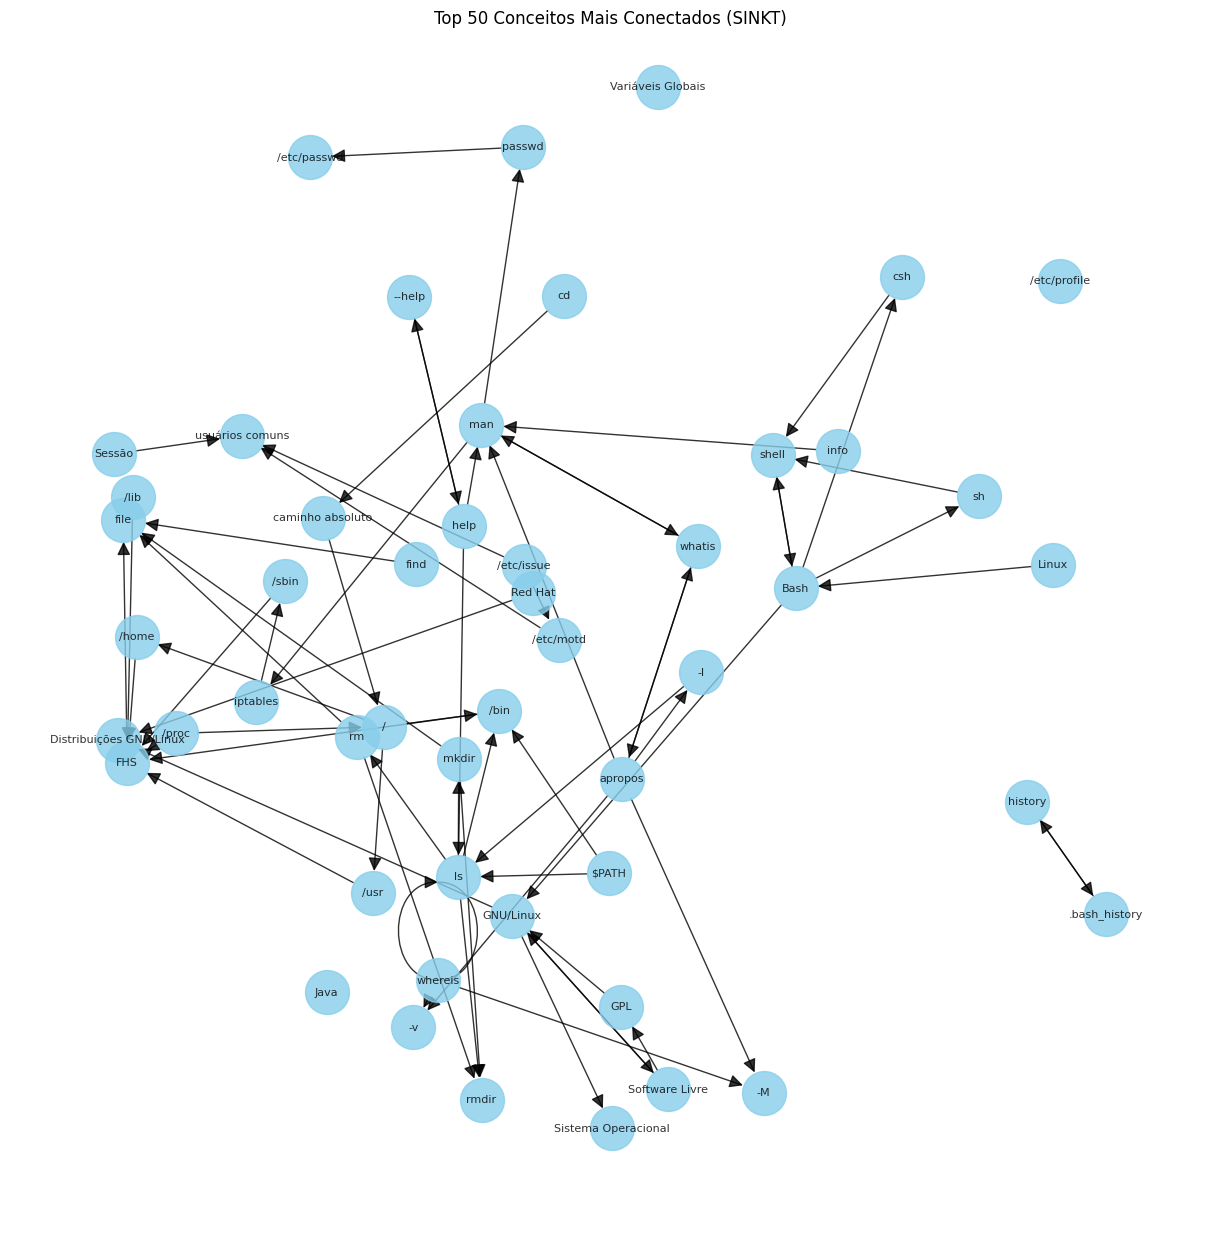

📊 Gráfico salvo em: output/01_extraction/graph_preview.png


In [7]:
# --- Consolidação e Visualização ---

# Remover duplicatas (mesma source, target e type)
unique_relations = {}
for r in extracted_relations:
    key = f"{r['source']}|{r['target']}|{r['type']}"
    if key not in unique_relations:
        unique_relations[key] = r

final_relations_list = list(unique_relations.values())
output_relations_path = f"{output_folder}/relations_initial.json" # NOME ALTERADO

if final_relations_list:
    # Salvar
    with open(output_relations_path, 'w', encoding='utf-8') as f:
        json.dump(final_relations_list, f, indent=4, ensure_ascii=False)
    print(f"💾 Relações salvas em: {output_relations_path}")
    
    # --- Visualização Básica do Grafo ---
    print("\nGerando visualização do grafo...")
    
    try:
        G = nx.DiGraph()
        
        # Adicionar nós
        for c in valid_concepts:
            G.add_node(c['nome'], tipo=c['tipo'])
            
        # Adicionar arestas
        for r in final_relations_list:
            G.add_edge(r['source'], r['target'], relation=r['type'])
            
        # Estatísticas
        print(f"Nós: {G.number_of_nodes()}")
        print(f"Arestas: {G.number_of_edges()}")
        print(f"Densidade: {nx.density(G):.4f}")
        
        # Plotagem Simples (Top 50 nós mais conectados para visualização limpa)
        plt.figure(figsize=(12, 12))
        degrees = dict(G.degree())
        # Pegar top 50 ou todos se for menor
        if degrees:
            top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:min(50, len(degrees))]
            subgraph = G.subgraph(top_nodes)
            
            pos = nx.spring_layout(subgraph, k=0.5, seed=42)
            nx.draw(subgraph, pos, 
                    with_labels=True, 
                    node_size=1000, 
                    node_color='skyblue', 
                    font_size=8, 
                    arrowsize=20, 
                    alpha=0.8)
            
            plt.title(f"Top {len(top_nodes)} Conceitos Mais Conectados (SINKT)")
            plt.savefig(f"{output_folder}/graph_preview.png")
            plt.show()
            print(f"📊 Gráfico salvo em: {output_folder}/graph_preview.png")
        else:
            print("Grafo vazio, sem visualização.")
        
    except Exception as e:
        print(f"Erro na visualização: {e}")
else:
    print("Nenhuma relação extraída para salvar.")